# Homework Week 4: E. Araya

## See solution at the end of this notebook.

$~$

$~$

# Modern Neural Networks

In this tutorial, we'll cover "modern" neural networks.  In this case that specifically means deep, residual, convolutional neural networks.  Notably, the field of machine learning is "moving on" a bit these days from convoltutional neural networks.  The latest models are what are called "transformers" - we won't cover them today or likely at all in this course, but they certainly claim to be the next Big Thing.

## Today's tutorial Agenda

We'll cover 3 things in the tutorial-focused portion of today's session:

1) ImageNet Dataset, from a high view.  (More next week!)

2) Recap of Convolutions, and the vanishing gradient problem

3) Residual Layers and the ResNet development.

## 1) ImageNet from a Mile High

In the 2010s, there was one dataset to rule them all: [ImageNet](https://www.image-net.org/).  We will use this dataset for the rest of this series since it's the territory of "Big Data."  The dataset is just about 200GB on disk, and contains 1.4M images to classify spread over 1000 classes.  Modern datasets from science are actually growing even bigger!  For today, we will use the data loading as a *black box*, paying no heed to how we're loading the data or what it's doing.  We will circle back next week, however, to get into this.

In [1]:
import tensorflow as tf
import json

In [2]:
# What's in this function?  Tune in next week ...
from ilsvrc_dataset import get_datasets

--------------------------------------------------------------------------

  Local host:   thetagpu06
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
class FakeHvd:
    
    def size(self): return 1
    
    def rank(self): return 0


with open("ilsvrc.json", 'r') as f: 
    config = json.load(f)

print(json.dumps(config, indent=4))
    
    
config['hvd'] = FakeHvd()



{
    "data": {
        "handler": "ilsvrc_dataset",
        "batch_size": 128,
        "train_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt",
        "test_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt",
        "shuffle_buffer": 200000,
        "reshuffle_each_iteration": true,
        "num_parallel_readers": 32,
        "prefetch_buffer_size": 10,
        "crop_image_size": [
            256,
            256
        ],
        "num_classes": 1000,
        "num_channels": 3
    }
}


In [4]:
train_ds, val_ds = get_datasets(config)

num labels: 1000
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt
input filelist contains 1281167 files, estimated batches per rank 10009
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt
input filelist contains 50000 files, estimated batches per rank 390


In [5]:
images, labels = next(iter(train_ds.take(1)))

In [6]:
print(images.shape)
print(labels.shape)

(128, 256, 256, 3)
(128,)


In [7]:
first_image = images[0]

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

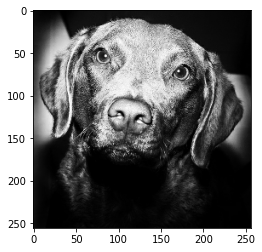

In [9]:
# Divide by 255 to put this in the range of 0-1 for floating point colors
plt.imshow(first_image/255.) 

## What is a convolution doing, again?

Convolution kernels are operating on entire images in small patches.  

![Convolution Kernel](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_02_17A-ConvolutionalNeuralNetworks-WHITEBG.png)


That's a **single** convolution.  Convolutional Layers are learning multiple filters:

![Convolution Layer](https://miro.medium.com/max/1400/1*u2el-HrqRPVk7x0xlvs_CA.png)

In [10]:
# Using 3 output filters here to simulate RGB.  
# You can - and SHOULD - use more for bigger networks
sample_conv_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=1)

In [11]:
# Apply this layer to all images:
modified_output = sample_conv_layer(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


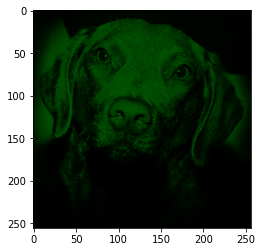

In [12]:
first_image = modified_output[0]
# Divide by 255 to put this in the range of 0-1 for floating point colors
plt.imshow(first_image/255.) 

This image is just as crisp as the original, but has had it's colors totally shifted.  That's expected: the convolution kernel size was just 1x1, or one pixel at a time.  So it's taking, for every pixel, the RGB value times a kernel (in this case, a vector):

$$ output = R*k_1 + G*k_2 + B*k_3$$


More generally, this becomes a sum over neighboring pixels (for kernel sizes > 1).

We also produced 3 output "filters" - here, RGB again, but it can be more!  Each output filter for a convolution layer will create a $k x k$ kernel for every input filter, that are all summed together.  The total number of parameters is then:

$$ n_{params} = N_{Input Filters} \times N_{Output Filters} \times k_{x} \times k_{y} $$

In [13]:
sample_conv_layer_7x7 = tf.keras.layers.Conv2D(filters=3, kernel_size=7)
modified_output_7x7 = sample_conv_layer_7x7(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


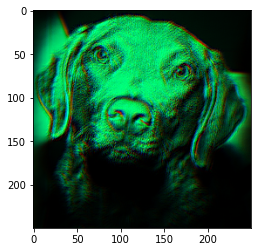

In [14]:
first_image = modified_output_7x7[0]
# Divide by 255 to put this in the range of 0-1 for floating point colors
plt.imshow(first_image/255.) 

This time the output is much blurrier - because this kernel has a 7x7 pixel size instead of a 1x1 pixel size.

### Strides, Padding, Output Size

To apply a convolution, one algorithm takes the first output pixel to be the one where the filter just fits into the top left corner of the input image, and scans over (and then down) one pixel at a time.  There is nothing special about that though!  Kernels can skip pixels to reduce the output image size (sometimes called an downsampling convolution) and they can start with incomplete corners of the input images (padding with 0) to preserve the same output size.

- **Padding** represents the operation of handling the corner and edge cases so the output image is the same size as the input image.  Often you will see "valid" (apply the kernel only in valid locations) or "same" (add padding to make sure the output is the same size).

- **Stride** represents how many pixels are skipped between applications of the convolution.

- **Bottleneck** Layers are special convolution layers that have kernel size = 1, stride = 1 that preserve the output size and only look at single pixels at at time - though they look at all filters on a pixel.  A bottleneck layer is mathematically the same as applying the same MLP to each individual pixel's filters.

## The case for ResNet: Vanishing Gradients

One of the motivations for the network we'll develop in the second half is the so-called "vanishing gradient problem":  The gradient of each layer depends on the gradient of each layer after it (remember the gradients flow backwards through the network).  Deeper and deeper networks that stack convolutions end up with smaller and smaller gradients in early layers.

In [15]:
class DenseLayer(tf.keras.Model):
    
    def __init__(self, n_filters):
        tf.keras.Model.__init__(self)
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )
        
    def __call__(self, inputs):
        
        x = inputs
        
        output1 = self.conv1(inputs)
        
        output1 = tf.keras.activations.sigmoid(output1)
        
        return output1
    
class ResidualLayer(tf.keras.Model):
    
    def __init__(self, n_filters):
        tf.keras.Model.__init__(self)
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )
        
        self.conv2 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )
    
    def __call__(self, inputs):
        
        x = inputs
        
        output1 = self.conv1(inputs)
        
        output1 = tf.keras.activations.sigmoid(output1)
        
        output2 = self.conv2(output1)

        return tf.keras.activations.sigmoid(output2 + x)
        

In [16]:
regular_layers  = [ DenseLayer(3) for i in range(100)]
residual_layers = [ ResidualLayer(3) for i in range(50)] # 2 convolutions per layer, so do half!

Apply these layers to the input data, and then compute a loss value (even it it's totally artificial!)

In [17]:
with tf.GradientTape() as tape:
    output = images
    for layer in regular_layers:
        output = layer(output)
    regular_loss = tf.reduce_mean(output)

Compute the gradients per layer:

In [18]:
regular_params = [l.trainable_weights for l in regular_layers]
gradients = tape.gradient(regular_loss, regular_params)

Lets do the same with the residual layers:

In [19]:
with tf.GradientTape() as tape:
    output = images
    for layer in residual_layers:
        output = layer(output)
    residual_loss = tf.reduce_mean(output)

In [20]:
residual_params = [l.trainable_weights for l in residual_layers]
residual_gradients = tape.gradient(residual_loss, residual_params)

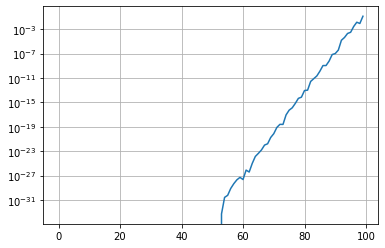

In [21]:
# Compute the ratio of the gradient to the weights for each layer:
regular_mean_ratio = []
for layer, grad in zip(regular_params, gradients):
    regular_mean_ratio.append(tf.abs(tf.reduce_max(grad[0]) / tf.reduce_max(layer[0])))
    
plt.plot(range(len(regular_mean_ratio)), regular_mean_ratio)
plt.grid()
plt.yscale("log")

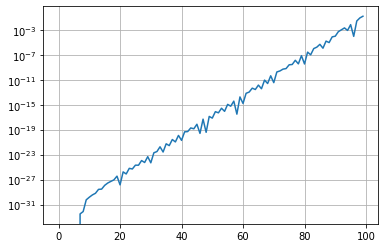

[thetagpu06:404135:0:404255] Caught signal 7 (Bus error: nonexistent physical address)


In [22]:
# Compute the ratio of the gradient to the weights for each layer:
residual_mean_ratio = []
for layer, grad in zip(residual_params, residual_gradients):

    residual_mean_ratio.append(tf.abs(tf.reduce_max(grad[0]) / tf.reduce_max(layer[0])))
    residual_mean_ratio.append(tf.abs(tf.reduce_max(grad[2]) / tf.reduce_max(layer[2])))

plt.plot(range(len(residual_mean_ratio)), residual_mean_ratio)
plt.yscale("log")
plt.grid()

The difference in the magnitude of the gradients is striking.  Yes, there are ways to keep the magnitude of the gradients more reasonable through normalization layers (and that helps in residual networks too!), but most cases that use residual connections show significant benefits compared to regular convolutional neural networks, especially as the networks get deeper.

# Homework: 

For homework this week, your job is to do the following:

- train ResNet34 for 1 epoch.  You are welcome to change parameters like batch size, learning rate, etc. as you like.

- Make a plot of the training accuracy and loss as a function of iteration.  You can put them on the same plot if you like, but it's not mandatory.

### Solution:

In [1]:
!ls

a.out		   output_file.dat		  train_resnet34_polaris.sh
homework.txt	   output_file.dat~		  train_resnet34.py
ilsvrc_dataset.py  __pycache__			  train_resnet34_thetagpu.sh
ilsvrc.json	   ResidualConvolutions_EA.ipynb


In [ ]:
'''
#Changes made in def train_epoch() for saving iteration, loss and acc
# in a file for plotting:

def train_epoch(i_epoch, step_in_epoch, train_ds, val_ds, network, optimizer, BATC
H_SIZE, checkpoint):
    # Here is our training loop!

    steps_per_epoch = int(1281167 / BATCH_SIZE)
    steps_validation = int(50000 / BATCH_SIZE)

    start = time.time()

    #EA: add output_file for plotting
    output_file = open('output_file.dat','w')
    output_file.write('iteration loss accuracy \n')
    output_file.close()
    for train_images, train_labels in train_ds.take(steps_per_epoch):
        if step_in_epoch > steps_per_epoch: break
        else: step_in_epoch.assign_add(1)

        # Peform the training step for this batch
        loss, acc = training_step(network, optimizer, train_images, train_labels)
        end = time.time()
        images_per_second = BATCH_SIZE / (end - start)
        print(f"Finished step {step_in_epoch.numpy()} of {steps_per_epoch} in epoc
h {i_epoch.numpy()},loss={loss:.3f}, acc={acc:.3f} ({images_per_second:.3f} img/s)
.")
        #EA: add output_file for plotting
        output_file = open('output_file.dat','a')
        output_file.write(f"{step_in_epoch.numpy()} {loss:.3f} {acc:.3f} \n")
        output_file.close()
        start = time.time()
'''

!python train_resnet34.py



Parameters set, preparing dataloading
--------------------------------------------------------------------------

  Local host:   thetagpu06
  Local device: mlx5_0
--------------------------------------------------------------------------
{
    "data": {
        "handler": "ilsvrc_dataset",
        "batch_size": 128,
        "train_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt",
        "test_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt",
        "shuffle_buffer": 200000,
        "reshuffle_each_iteration": true,
        "num_parallel_readers": 32,
        "prefetch_buffer_size": 10,
        "crop_image_size": [
            256,
            256
        ],
        "num_classes": 1000,
        "num_channels": 3
    }
}
num labels: 1000
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt
input filelist contains 1281167 files, estimated batches per rank 5004
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt
input fi

Finished step 66 of 5004 in epoch 0,loss=5.271, acc=0.000 (799.989 img/s).
Finished step 67 of 5004 in epoch 0,loss=5.352, acc=0.023 (718.491 img/s).
Finished step 68 of 5004 in epoch 0,loss=5.363, acc=0.016 (762.483 img/s).
Finished step 69 of 5004 in epoch 0,loss=5.237, acc=0.031 (453.463 img/s).
Finished step 70 of 5004 in epoch 0,loss=5.346, acc=0.020 (636.302 img/s).
Finished step 71 of 5004 in epoch 0,loss=5.258, acc=0.020 (671.863 img/s).
Finished step 72 of 5004 in epoch 0,loss=5.297, acc=0.020 (761.340 img/s).
Finished step 73 of 5004 in epoch 0,loss=5.318, acc=0.016 (532.939 img/s).
Finished step 74 of 5004 in epoch 0,loss=5.370, acc=0.016 (752.840 img/s).
Finished step 75 of 5004 in epoch 0,loss=5.236, acc=0.020 (760.496 img/s).
Finished step 76 of 5004 in epoch 0,loss=5.370, acc=0.008 (762.560 img/s).
Finished step 77 of 5004 in epoch 0,loss=5.340, acc=0.023 (760.860 img/s).
Finished step 78 of 5004 in epoch 0,loss=5.282, acc=0.023 (674.272 img/s).
Finished step 79 of 5004 

Finished step 175 of 5004 in epoch 0,loss=5.110, acc=0.027 (604.309 img/s).
Finished step 176 of 5004 in epoch 0,loss=5.023, acc=0.012 (731.266 img/s).
Finished step 177 of 5004 in epoch 0,loss=5.071, acc=0.035 (730.936 img/s).
Finished step 178 of 5004 in epoch 0,loss=5.252, acc=0.008 (718.835 img/s).
Finished step 179 of 5004 in epoch 0,loss=5.211, acc=0.031 (753.991 img/s).
Finished step 180 of 5004 in epoch 0,loss=5.087, acc=0.031 (779.139 img/s).
Finished step 181 of 5004 in epoch 0,loss=5.142, acc=0.031 (741.133 img/s).
Finished step 182 of 5004 in epoch 0,loss=5.038, acc=0.035 (727.201 img/s).
Finished step 183 of 5004 in epoch 0,loss=5.285, acc=0.039 (656.692 img/s).
Finished step 184 of 5004 in epoch 0,loss=5.162, acc=0.027 (744.539 img/s).
Finished step 185 of 5004 in epoch 0,loss=5.096, acc=0.027 (685.927 img/s).
Finished step 186 of 5004 in epoch 0,loss=5.159, acc=0.027 (733.462 img/s).
Finished step 187 of 5004 in epoch 0,loss=5.080, acc=0.043 (752.495 img/s).
Finished ste

Finished step 283 of 5004 in epoch 0,loss=5.047, acc=0.047 (744.469 img/s).
Finished step 284 of 5004 in epoch 0,loss=4.894, acc=0.074 (745.408 img/s).
Finished step 285 of 5004 in epoch 0,loss=5.011, acc=0.043 (730.016 img/s).
Finished step 286 of 5004 in epoch 0,loss=4.973, acc=0.039 (1119.715 img/s).
Finished step 287 of 5004 in epoch 0,loss=5.014, acc=0.043 (695.988 img/s).
Finished step 288 of 5004 in epoch 0,loss=5.042, acc=0.047 (771.589 img/s).
Finished step 289 of 5004 in epoch 0,loss=5.171, acc=0.039 (706.642 img/s).
Finished step 290 of 5004 in epoch 0,loss=5.076, acc=0.047 (803.526 img/s).
Finished step 291 of 5004 in epoch 0,loss=5.187, acc=0.023 (560.748 img/s).
Finished step 292 of 5004 in epoch 0,loss=5.003, acc=0.039 (652.131 img/s).
Finished step 293 of 5004 in epoch 0,loss=5.127, acc=0.020 (629.917 img/s).
Finished step 294 of 5004 in epoch 0,loss=5.063, acc=0.051 (677.299 img/s).
Finished step 295 of 5004 in epoch 0,loss=5.128, acc=0.031 (607.988 img/s).
Finished st

Finished step 391 of 5004 in epoch 0,loss=4.998, acc=0.051 (650.329 img/s).
Finished step 392 of 5004 in epoch 0,loss=4.901, acc=0.062 (799.436 img/s).
Finished step 393 of 5004 in epoch 0,loss=5.001, acc=0.055 (655.103 img/s).
Finished step 394 of 5004 in epoch 0,loss=5.180, acc=0.039 (802.083 img/s).
Finished step 395 of 5004 in epoch 0,loss=5.019, acc=0.059 (713.719 img/s).
Finished step 396 of 5004 in epoch 0,loss=4.912, acc=0.043 (788.986 img/s).
Finished step 397 of 5004 in epoch 0,loss=4.978, acc=0.062 (721.954 img/s).
Finished step 398 of 5004 in epoch 0,loss=4.903, acc=0.059 (660.517 img/s).
Finished step 399 of 5004 in epoch 0,loss=5.025, acc=0.035 (757.057 img/s).
Finished step 400 of 5004 in epoch 0,loss=4.968, acc=0.035 (694.880 img/s).
Finished step 401 of 5004 in epoch 0,loss=4.980, acc=0.062 (559.845 img/s).
Finished step 402 of 5004 in epoch 0,loss=4.952, acc=0.047 (748.511 img/s).
Finished step 403 of 5004 in epoch 0,loss=5.015, acc=0.043 (684.268 img/s).
Finished ste

Finished step 499 of 5004 in epoch 0,loss=5.042, acc=0.062 (617.277 img/s).
Finished step 500 of 5004 in epoch 0,loss=5.000, acc=0.074 (708.731 img/s).
Finished step 501 of 5004 in epoch 0,loss=5.123, acc=0.062 (710.468 img/s).
Finished step 502 of 5004 in epoch 0,loss=4.895, acc=0.031 (768.614 img/s).
Finished step 503 of 5004 in epoch 0,loss=4.950, acc=0.074 (748.203 img/s).
Finished step 504 of 5004 in epoch 0,loss=5.037, acc=0.051 (647.795 img/s).
Finished step 505 of 5004 in epoch 0,loss=5.204, acc=0.070 (782.537 img/s).
Finished step 506 of 5004 in epoch 0,loss=5.186, acc=0.062 (535.399 img/s).
Finished step 507 of 5004 in epoch 0,loss=5.094, acc=0.043 (692.653 img/s).
Finished step 508 of 5004 in epoch 0,loss=4.935, acc=0.086 (738.822 img/s).
Finished step 509 of 5004 in epoch 0,loss=5.099, acc=0.023 (667.736 img/s).
Finished step 510 of 5004 in epoch 0,loss=4.965, acc=0.066 (1096.018 img/s).
Finished step 511 of 5004 in epoch 0,loss=4.935, acc=0.051 (975.292 img/s).
Finished st

Finished step 607 of 5004 in epoch 0,loss=5.390, acc=0.031 (451.908 img/s).
Finished step 608 of 5004 in epoch 0,loss=5.094, acc=0.055 (729.743 img/s).
Finished step 609 of 5004 in epoch 0,loss=5.199, acc=0.074 (725.485 img/s).
Finished step 610 of 5004 in epoch 0,loss=5.245, acc=0.039 (766.833 img/s).
Finished step 611 of 5004 in epoch 0,loss=5.103, acc=0.031 (708.139 img/s).
Finished step 612 of 5004 in epoch 0,loss=5.164, acc=0.031 (683.032 img/s).
Finished step 613 of 5004 in epoch 0,loss=5.061, acc=0.035 (778.612 img/s).
Finished step 614 of 5004 in epoch 0,loss=5.101, acc=0.027 (751.574 img/s).
Finished step 615 of 5004 in epoch 0,loss=5.158, acc=0.055 (758.703 img/s).
Finished step 616 of 5004 in epoch 0,loss=5.090, acc=0.047 (717.906 img/s).
Finished step 617 of 5004 in epoch 0,loss=5.103, acc=0.047 (727.099 img/s).
Finished step 618 of 5004 in epoch 0,loss=4.898, acc=0.039 (741.151 img/s).
Finished step 619 of 5004 in epoch 0,loss=5.049, acc=0.062 (675.904 img/s).
Finished ste

Finished step 715 of 5004 in epoch 0,loss=5.109, acc=0.047 (775.411 img/s).
Finished step 716 of 5004 in epoch 0,loss=4.993, acc=0.066 (719.291 img/s).
Finished step 717 of 5004 in epoch 0,loss=5.050, acc=0.062 (686.461 img/s).
Finished step 718 of 5004 in epoch 0,loss=4.852, acc=0.062 (799.243 img/s).
Finished step 719 of 5004 in epoch 0,loss=5.020, acc=0.066 (708.351 img/s).
Finished step 720 of 5004 in epoch 0,loss=4.822, acc=0.047 (696.401 img/s).
Finished step 721 of 5004 in epoch 0,loss=5.105, acc=0.082 (718.028 img/s).
Finished step 722 of 5004 in epoch 0,loss=4.961, acc=0.094 (556.926 img/s).
Finished step 723 of 5004 in epoch 0,loss=5.074, acc=0.059 (1013.723 img/s).
Finished step 724 of 5004 in epoch 0,loss=5.175, acc=0.062 (1071.083 img/s).
Finished step 725 of 5004 in epoch 0,loss=5.231, acc=0.062 (988.117 img/s).
Finished step 726 of 5004 in epoch 0,loss=5.031, acc=0.062 (1068.640 img/s).
Finished step 727 of 5004 in epoch 0,loss=5.071, acc=0.039 (742.084 img/s).
Finished 

Finished step 823 of 5004 in epoch 0,loss=5.039, acc=0.078 (748.591 img/s).
Finished step 824 of 5004 in epoch 0,loss=5.134, acc=0.070 (644.546 img/s).
Finished step 825 of 5004 in epoch 0,loss=5.007, acc=0.082 (770.919 img/s).
Finished step 826 of 5004 in epoch 0,loss=5.045, acc=0.047 (545.710 img/s).
Finished step 827 of 5004 in epoch 0,loss=5.012, acc=0.043 (734.971 img/s).
Finished step 828 of 5004 in epoch 0,loss=5.018, acc=0.059 (640.894 img/s).
Finished step 829 of 5004 in epoch 0,loss=5.219, acc=0.043 (735.339 img/s).
Finished step 830 of 5004 in epoch 0,loss=4.955, acc=0.066 (806.043 img/s).
Finished step 831 of 5004 in epoch 0,loss=4.884, acc=0.066 (1087.491 img/s).
Finished step 832 of 5004 in epoch 0,loss=5.004, acc=0.082 (1024.435 img/s).
Finished step 833 of 5004 in epoch 0,loss=5.099, acc=0.062 (1079.937 img/s).
Finished step 834 of 5004 in epoch 0,loss=4.944, acc=0.062 (1006.038 img/s).
Finished step 835 of 5004 in epoch 0,loss=5.069, acc=0.082 (1029.622 img/s).
Finishe

Finished step 931 of 5004 in epoch 0,loss=4.992, acc=0.055 (982.858 img/s).
Finished step 932 of 5004 in epoch 0,loss=5.125, acc=0.066 (1055.830 img/s).
Finished step 933 of 5004 in epoch 0,loss=5.007, acc=0.070 (1019.150 img/s).
Finished step 934 of 5004 in epoch 0,loss=4.940, acc=0.070 (950.962 img/s).
Finished step 935 of 5004 in epoch 0,loss=5.272, acc=0.055 (600.262 img/s).
Finished step 936 of 5004 in epoch 0,loss=4.826, acc=0.090 (731.032 img/s).
Finished step 937 of 5004 in epoch 0,loss=5.183, acc=0.047 (689.568 img/s).
Finished step 938 of 5004 in epoch 0,loss=5.001, acc=0.074 (626.100 img/s).
Finished step 939 of 5004 in epoch 0,loss=4.965, acc=0.059 (696.656 img/s).
Finished step 940 of 5004 in epoch 0,loss=5.134, acc=0.074 (695.949 img/s).
Finished step 941 of 5004 in epoch 0,loss=5.196, acc=0.055 (794.633 img/s).
Finished step 942 of 5004 in epoch 0,loss=5.231, acc=0.105 (570.446 img/s).
Finished step 943 of 5004 in epoch 0,loss=4.917, acc=0.062 (726.504 img/s).
Finished s

Finished step 1039 of 5004 in epoch 0,loss=5.022, acc=0.059 (1134.349 img/s).
Finished step 1040 of 5004 in epoch 0,loss=4.859, acc=0.109 (1058.190 img/s).
Finished step 1041 of 5004 in epoch 0,loss=5.225, acc=0.035 (855.674 img/s).
Finished step 1042 of 5004 in epoch 0,loss=4.953, acc=0.062 (700.117 img/s).
Finished step 1043 of 5004 in epoch 0,loss=5.010, acc=0.066 (619.970 img/s).
Finished step 1044 of 5004 in epoch 0,loss=4.963, acc=0.074 (760.070 img/s).
Finished step 1045 of 5004 in epoch 0,loss=4.871, acc=0.078 (788.660 img/s).
Finished step 1046 of 5004 in epoch 0,loss=4.953, acc=0.074 (738.639 img/s).
Finished step 1047 of 5004 in epoch 0,loss=5.192, acc=0.070 (734.541 img/s).
Finished step 1048 of 5004 in epoch 0,loss=5.153, acc=0.094 (709.850 img/s).
Finished step 1049 of 5004 in epoch 0,loss=5.172, acc=0.062 (680.470 img/s).
Finished step 1050 of 5004 in epoch 0,loss=4.992, acc=0.090 (748.876 img/s).
Finished step 1051 of 5004 in epoch 0,loss=5.003, acc=0.055 (761.363 img/s

Finished step 1146 of 5004 in epoch 0,loss=5.107, acc=0.070 (687.495 img/s).
Finished step 1147 of 5004 in epoch 0,loss=5.172, acc=0.043 (741.321 img/s).
Finished step 1148 of 5004 in epoch 0,loss=4.986, acc=0.105 (701.788 img/s).
Finished step 1149 of 5004 in epoch 0,loss=5.024, acc=0.066 (604.856 img/s).
Finished step 1150 of 5004 in epoch 0,loss=5.108, acc=0.066 (713.045 img/s).
Finished step 1151 of 5004 in epoch 0,loss=5.062, acc=0.070 (745.300 img/s).
Finished step 1152 of 5004 in epoch 0,loss=5.119, acc=0.074 (658.833 img/s).
Finished step 1153 of 5004 in epoch 0,loss=5.076, acc=0.078 (744.871 img/s).
Finished step 1154 of 5004 in epoch 0,loss=5.086, acc=0.078 (665.259 img/s).
Finished step 1155 of 5004 in epoch 0,loss=5.072, acc=0.070 (754.356 img/s).
Finished step 1156 of 5004 in epoch 0,loss=4.911, acc=0.086 (726.896 img/s).
Finished step 1157 of 5004 in epoch 0,loss=5.109, acc=0.059 (781.665 img/s).
Finished step 1158 of 5004 in epoch 0,loss=4.908, acc=0.102 (785.008 img/s).

Finished step 1253 of 5004 in epoch 0,loss=5.120, acc=0.074 (926.496 img/s).
Finished step 1254 of 5004 in epoch 0,loss=5.042, acc=0.098 (771.831 img/s).
Finished step 1255 of 5004 in epoch 0,loss=4.997, acc=0.059 (703.175 img/s).
Finished step 1256 of 5004 in epoch 0,loss=5.057, acc=0.066 (734.456 img/s).
Finished step 1257 of 5004 in epoch 0,loss=5.069, acc=0.062 (671.893 img/s).
Finished step 1258 of 5004 in epoch 0,loss=5.156, acc=0.090 (714.138 img/s).
Finished step 1259 of 5004 in epoch 0,loss=4.970, acc=0.062 (668.049 img/s).
Finished step 1260 of 5004 in epoch 0,loss=4.986, acc=0.059 (684.500 img/s).
Finished step 1261 of 5004 in epoch 0,loss=5.060, acc=0.074 (770.908 img/s).
Finished step 1262 of 5004 in epoch 0,loss=5.092, acc=0.059 (718.617 img/s).
Finished step 1263 of 5004 in epoch 0,loss=5.067, acc=0.074 (679.906 img/s).
Finished step 1264 of 5004 in epoch 0,loss=4.930, acc=0.109 (784.508 img/s).
Finished step 1265 of 5004 in epoch 0,loss=5.018, acc=0.066 (669.999 img/s).

Finished step 1360 of 5004 in epoch 0,loss=4.817, acc=0.102 (717.440 img/s).
Finished step 1361 of 5004 in epoch 0,loss=4.878, acc=0.082 (790.944 img/s).
Finished step 1362 of 5004 in epoch 0,loss=5.207, acc=0.086 (656.151 img/s).
Finished step 1363 of 5004 in epoch 0,loss=4.826, acc=0.078 (766.428 img/s).
Finished step 1364 of 5004 in epoch 0,loss=4.874, acc=0.062 (763.231 img/s).
Finished step 1365 of 5004 in epoch 0,loss=4.900, acc=0.090 (692.470 img/s).
Finished step 1366 of 5004 in epoch 0,loss=5.005, acc=0.074 (721.682 img/s).
Finished step 1367 of 5004 in epoch 0,loss=5.086, acc=0.082 (710.422 img/s).
Finished step 1368 of 5004 in epoch 0,loss=5.078, acc=0.055 (811.223 img/s).
Finished step 1369 of 5004 in epoch 0,loss=5.259, acc=0.082 (692.285 img/s).
Finished step 1370 of 5004 in epoch 0,loss=5.106, acc=0.086 (709.614 img/s).
Finished step 1371 of 5004 in epoch 0,loss=4.946, acc=0.090 (761.277 img/s).
Finished step 1372 of 5004 in epoch 0,loss=5.074, acc=0.062 (679.680 img/s).

Finished step 1467 of 5004 in epoch 0,loss=5.133, acc=0.082 (1104.057 img/s).
Finished step 1468 of 5004 in epoch 0,loss=4.962, acc=0.070 (1024.373 img/s).
Finished step 1469 of 5004 in epoch 0,loss=5.121, acc=0.082 (1040.035 img/s).
Finished step 1470 of 5004 in epoch 0,loss=5.003, acc=0.094 (981.481 img/s).
Finished step 1471 of 5004 in epoch 0,loss=5.341, acc=0.055 (1122.906 img/s).
Finished step 1472 of 5004 in epoch 0,loss=5.137, acc=0.062 (777.718 img/s).
Finished step 1473 of 5004 in epoch 0,loss=4.816, acc=0.133 (776.789 img/s).
Finished step 1474 of 5004 in epoch 0,loss=5.212, acc=0.070 (706.246 img/s).
Finished step 1475 of 5004 in epoch 0,loss=4.671, acc=0.172 (784.397 img/s).
Finished step 1476 of 5004 in epoch 0,loss=4.954, acc=0.078 (658.521 img/s).
Finished step 1477 of 5004 in epoch 0,loss=5.054, acc=0.086 (759.277 img/s).
Finished step 1478 of 5004 in epoch 0,loss=4.955, acc=0.078 (657.304 img/s).
Finished step 1479 of 5004 in epoch 0,loss=5.083, acc=0.082 (649.887 img

Finished step 1574 of 5004 in epoch 0,loss=4.905, acc=0.102 (755.286 img/s).
Finished step 1575 of 5004 in epoch 0,loss=4.995, acc=0.109 (735.471 img/s).
Finished step 1576 of 5004 in epoch 0,loss=5.097, acc=0.105 (711.714 img/s).
Finished step 1577 of 5004 in epoch 0,loss=5.266, acc=0.059 (698.524 img/s).
Finished step 1578 of 5004 in epoch 0,loss=5.115, acc=0.105 (663.375 img/s).
Finished step 1579 of 5004 in epoch 0,loss=5.222, acc=0.074 (777.776 img/s).
Finished step 1580 of 5004 in epoch 0,loss=4.781, acc=0.086 (731.875 img/s).
Finished step 1581 of 5004 in epoch 0,loss=5.190, acc=0.090 (778.067 img/s).
Finished step 1582 of 5004 in epoch 0,loss=4.983, acc=0.078 (652.348 img/s).
Finished step 1583 of 5004 in epoch 0,loss=5.310, acc=0.078 (684.998 img/s).
Finished step 1584 of 5004 in epoch 0,loss=4.987, acc=0.078 (776.214 img/s).
Finished step 1585 of 5004 in epoch 0,loss=5.162, acc=0.074 (789.383 img/s).
Finished step 1586 of 5004 in epoch 0,loss=4.989, acc=0.113 (747.163 img/s).

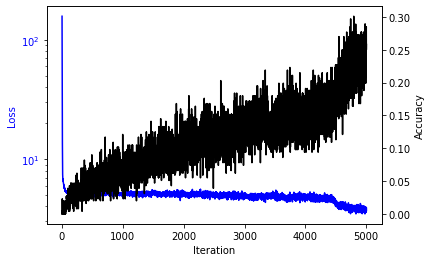

In [2]:
#plot:
import matplotlib.pyplot as plt
from numpy import loadtxt

data = loadtxt('output_file.dat', dtype='float', skiprows=1)
iteration = data[:5003,0]
loss = data[:5003,1]
acc = data[:5003,2]

fig, loss_ax = plt.subplots()
loss_ax.set_xlabel('Iteration')
loss_ax.set_ylabel('Loss',color = 'Blue')
loss_ax.plot(iteration,loss, color = 'Blue')
loss_ax.tick_params(axis='y', labelcolor='Blue')
plt.yscale("log")

acc_ax = loss_ax.twinx()
acc_ax.set_ylabel('Accuracy',color = 'Black')
acc_ax.plot(iteration,acc,color='Black')
acc_ax.tick_params(axis='y', labelcolor='Black')
